# GCRA

Rate limiting with the [Generic Cell Rate Algorithim](https://en.wikipedia.org/wiki/Generic_cell_rate_algorithm)

In [105]:
from generic_cell_rate_algorithm.throttle import RateLimit

# Create mock data stores

RATE_LIMIT_DB = {"count": 100, "period": 60}
THROTTLE_STATE_DB = [
    {"level": 0, "tat": 0, "allocation": 50},
    {"level": 0, "tat": 0, "allocation": 50},
    {"level": 1, "tat": 0, "allocation": 50},
    {"level": 2, "tat": 0, "allocation": 25},
    {"level": 3, "tat": 0, "allocation": 10},
]

In [106]:
from generic_cell_rate_algorithm import throttle


# define our data store interfaces
class RateLimitDB(throttle.RateLimitIO):
    def __init__(self, rate_limit_db):
        self.db = rate_limit_db

    def read(self):
        return throttle.RateLimit(count=self.db['count'], period=self.db['period'])


class ThrottleDB(throttle.ThrottleStateIO):
    def __init__(self, throttle_db):
        self.db = throttle_db

    def read(self):
        result = list()
        for id, row in enumerate(self.db):
            state = throttle.ThrottleState(
                tat=row['tat'],
                level=row['level'],
                allocation=row['allocation'],
                id=id
            )
            result.append(state)
        return result

    def write(self, previous, new):
        self.db[previous.id]['tat'] = new.tat


rate_limit_db = RateLimitDB(RATE_LIMIT_DB)
throttle_db = ThrottleDB(THROTTLE_STATE_DB)

print(rate_limit_db.read())
print(throttle_db.read())

RateLimit(count=100, period=60)
[ThrottleState(tat=0, level=0, allocation=50, id=0), ThrottleState(tat=0, level=0, allocation=50, id=1), ThrottleState(tat=0, level=1, allocation=50, id=2), ThrottleState(tat=0, level=2, allocation=25, id=3), ThrottleState(tat=0, level=3, allocation=10, id=4)]


In [169]:
# Create a fake instance of time that allows us to have instant gratification
from tests.conftest import TimeWarp

time = TimeWarp()

# Create a real instance of time
# import time

# Logger for viewing throttling
class TimeCard:
    def __init__(self):
        self._x0 = None
        self.log = list()

    def __call__(self):
        t = time.time()
        self._x0 = self._x0 or t
        self.log.append(t - self._x0)

    def clear(self):
        self._x0 = None
        self.log = list()

    @property
    def count(self):
        return np.arange(len(self.log))

    @property
    def time(self):
        return np.array(self.log)

    @property
    def rate(self):
        return self.count/np.maximum(1e-3, self.time)

time_card = TimeCard()

In [170]:
# Create our limiter instance
grca = throttle.GCRA(rate_limit_db, throttle_db, time)


def fn(level: int):
    @grca.throttle(level=level)
    def _fn():
        time_card()
        return None
    return _fn()

In [171]:
import matplotlib.pyplot as plt
import numpy as np

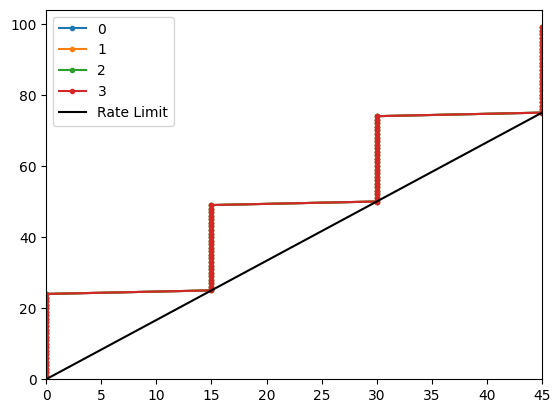

In [172]:
for level in range(4):
    time_card.clear()
    for _ in range(100):
        fn(level=level)
    plt.plot(time_card.time, time_card.count, '.-', label=level)


rate_limit = rate_limit_db.read()
plt.plot(time_card.time, time_card.time * rate_limit.rate, label="Rate Limit", color='k')
plt.xlim(0, time_card.time[-1])
plt.ylim(0, None)
plt.legend()
plt.show()

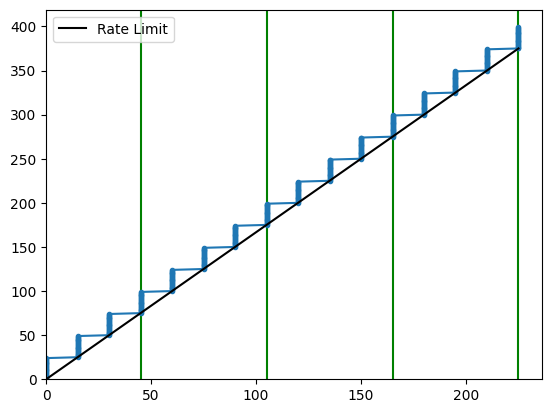

In [173]:
time_card.clear()
for level in range(4):
    for _ in range(100):
        fn(level=level)
    plt.axvline(time_card.time[-1], color='green')

plt.plot(time_card.time, time_card.count, '.-')

rate_limit = rate_limit_db.read()
plt.plot(time_card.time, time_card.time * rate_limit.rate, label="Rate Limit", color='k')
plt.xlim(0, None)
plt.ylim(0, None)
plt.legend()
plt.show()

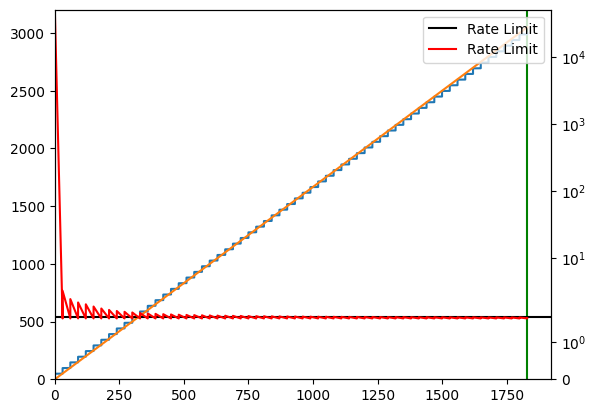

In [186]:
# Allow a burst of 25 calls while maintaining global limits
BURST_THROTTLE_STATE_DB = [{"level": 0, "tat": 0, "allocation": 100} for i in range(50)]
BURST_THROTTLE_STATE_DB[-1]['level'] = 100

throttle_db = ThrottleDB(BURST_THROTTLE_STATE_DB)
grca = throttle.GCRA(rate_limit_db, throttle_db, time)

def fn(level: int):
    @grca.throttle(level=level)
    def _fn():
        # time.sleep(1e-3)
        time_card()
        return None
    return _fn()


time_card.clear()

for _ in range(3000):
    fn(level=0)

plt.axvline(time_card.time[-1], color='green')
plt.plot(time_card.time, time_card.count, '-')
plt.plot(time_card.time, rate_limit.rate * time_card.time)
plt.xlim(0, None)
plt.ylim(0, None)

plt.twinx()
rate_limit = rate_limit_db.read()
plt.axhline(rate_limit.rate, label="Rate Limit", color='k')
plt.plot(time_card.time, time_card.rate, label="Rate Limit", color='red')

plt.ylim(0, None)
plt.yscale('symlog')
plt.legend()
plt.show()

In [187]:
throttle_db.read()

[ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=0),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=1),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=2),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=3),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=4),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=5),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=6),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=7),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=8),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=9),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=10),
 ThrottleState(tat=44212.689196799285, level=0, allocation=100, id=11),
 ThrottleState(tat=44212.689196799285, level=0, allocation=100, id=12),
 ThrottleState(tat=44212.689196799285, level=0, allocation=100, id=13),
 T

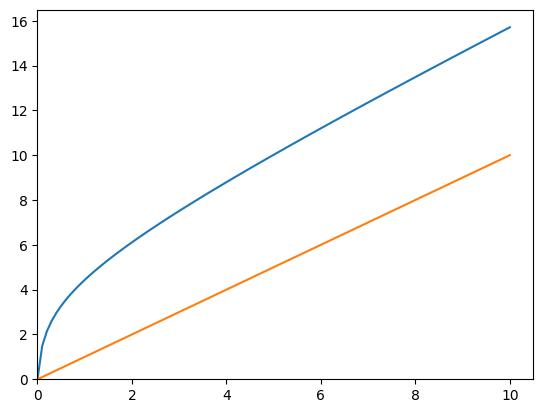

In [27]:

x = np.linspace(0, 10, 100)
f = np.log(30*x+1) + x

plt.plot(x, f)
plt.plot(x, x)
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

# Placeholder for some work on variable rate limits

This is an interesting but vexing concept that allows the traversal of a rate limiting function based on accumulated wait time.

The idea is that with the additional storage of the current x of the rate function f(x)... We can continually adjust the rate limit to be "optimal" for a rate limiting system that has multiple rate limiting constraints.  For instance you could prioritize burst trafic at the expense of the longer term rate or prioritize smoothing traffic by reducing the burst trafic and maximizing the long term rate.



In [ ]:
class VariableRate:
    def __init__(self, burst_rate: RateLimit, sustained_rate: RateLimit):
        self.burst_rate = burst_rate
        self.sustained_rate = sustained_rate
        self._min = self.burst_rate.inverse
        self._max = self.sustained_rate.period
        self._x = self._min

        a = burst_rate.count
        b = burst_rate.period
        c = sustained_rate.count
        d = sustained_rate.period
        ln = math.log
        self._a = -(a*d - b * c) / (b*ln(d+1) - d*ln(b+1))
        self._b = -(c * ln(b+1) - a*ln(d+1))/(b*ln(d+1) - d*ln(b+1))

    def _count(self, x):
        return self._a * math.log(x + 1) + self._b * x

    def _rate(self, x):
        return self._a/(x + 1) + self._b

    def _inverse(self, x):
        return 1/self._rate(x)

    @property
    def count(self):
        return self._count(self._x)

    @property
    def period(self):
        return self._x

    @property
    def rate(self):
        return self._rate(self._x)

    @property
    def inverse(self):
        return self._inverse(self._x)

    def update(self, wait_time: float):
        self._x += min(wait_time, self.inverse)
        self._x = min(max(self._x, self._min), self._max)

In [152]:
from generic_cell_rate_algorithm.throttle import RateLimit, GCRA
from tests.conftest import RateLimitInterface, ThrottleStateInterface, throttle_state_row, MockEndpoint, TimeWarp

import numpy as np
import matplotlib.pyplot as plt

burst = RateLimit(count=600, period=900)
sustained = RateLimit(count=6000, period=86400)

# setup throttle
rate_limits = [
    burst,
    sustained,
]

rate_io = RateLimitInterface(rate_limits)

throttle_io = ThrottleStateInterface([
    throttle_state_row(id=0, level=0, tat=0, allocation=1),
])

time = TimeWarp()

gcra = GCRA(rate_io, throttle_io, time=time)

# Set up the mock api endpoint
endpoint = MockEndpoint(time, rate_limits, fixed_period=True)

# setup our mock usage of the endpoint
@gcra.throttle()
def api_request(*args, **kwargs):
    return endpoint.make_request(*args, **kwargs)

# Bombard the endpoint with requests
for _ in range(int(1.25*sustained.count)):
    api_request()



def rolling_rate(x, dx):
    count = list()
    for i, end in enumerate(x):
        n = np.sum(x[:i+1] > end - dx)
        count.append(n)
    return np.array(count)/dx


class Results:
    def __init__(self, log, burst, sustained):
        self.count = np.arange(len(log))
        self.time = np.array(log)
        self.avg_rate = self.count/np.maximum(1e-3, self.time)
        self.rate = np.zeros_like(self.count, dtype=np.float64)
        self.rate[1:] = 1/np.diff(self.time)
        self.burst_rate = rolling_rate(self.time, burst.period)
        self.sustained_rate = rolling_rate(self.time, sustained.period)

results = Results(endpoint.log, burst, sustained)
burst.usage = 0
sustained.usage = 0

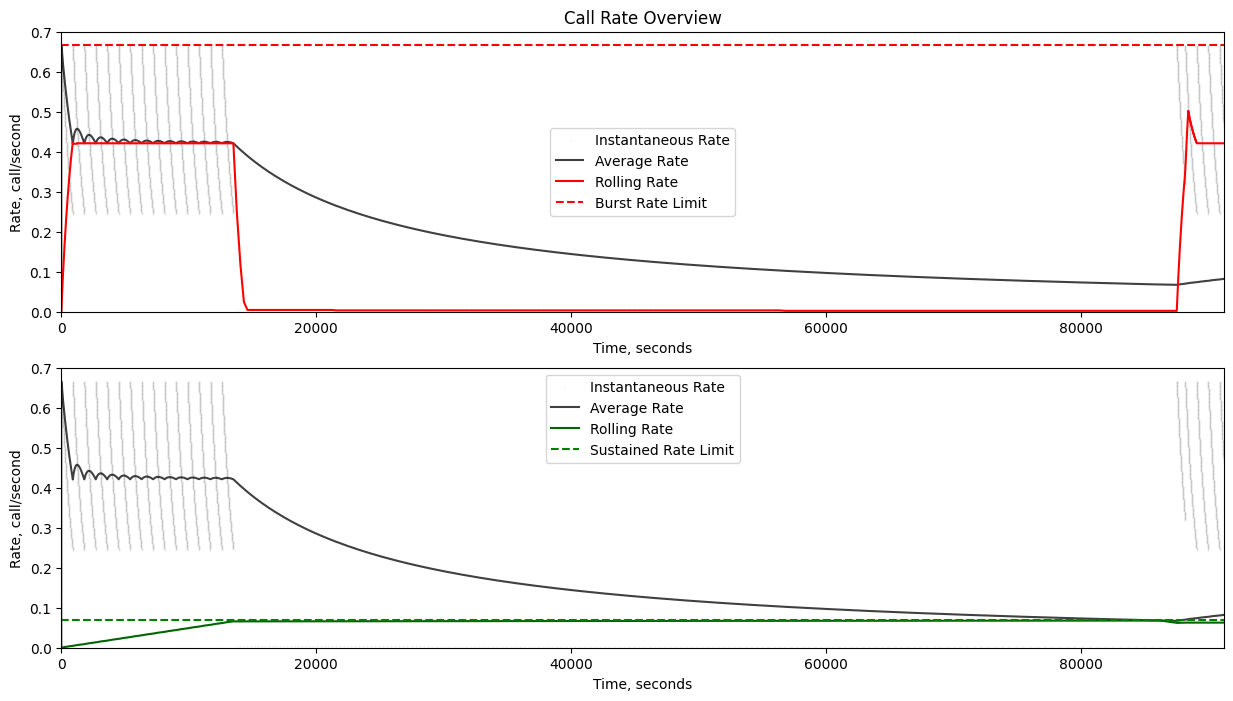

In [194]:
def show_overview(results, burst, sustained):
    fig, ax = plt.subplots(2, 1 ,figsize=(15, 8))
    ax[0].set_title("Call Rate Overview")

    ax[0].scatter(results.time, results.rate, marker='.', s=1, alpha=0.05, color='k', label='Instantaneous Rate')
    ax[0].plot(results.time, results.avg_rate, color='k', alpha=0.75, label='Average Rate')
    ax[0].plot(results.time, results.burst_rate, color='red', label='Rolling Rate')
    ax[0].axhline(burst.rate, color='red', alpha=1.0, ls='--', label='Burst Rate Limit')

    ax[0].set_xlim(results.time[0], results.time[-1])
    ax[0].set_ylim(0, None)
    ax[0].set_xlabel("Time, seconds")
    ax[0].set_ylabel("Rate, call/second")
    ax[0].legend()

    ax[1].scatter(results.time, results.rate, marker='.', s=1, alpha=0.05, color='k', label='Instantaneous Rate')
    ax[1].plot(results.time, results.avg_rate, color='k', alpha=0.75, label='Average Rate')
    ax[1].plot(results.time, results.sustained_rate, '-', color='darkgreen', label='Rolling Rate')
    ax[1].axhline(sustained.rate, color='green', alpha=1.0, ls='--', label='Sustained Rate Limit')

    ax[1].legend()
    ax[1].set_xlim(results.time[0], results.time[-1])
    ax[1].set_ylim(0, None)
    ax[1].set_xlabel("Time, seconds")
    ax[1].set_ylabel("Rate, call/second")
    plt.show()

show_overview(results, burst, sustained)

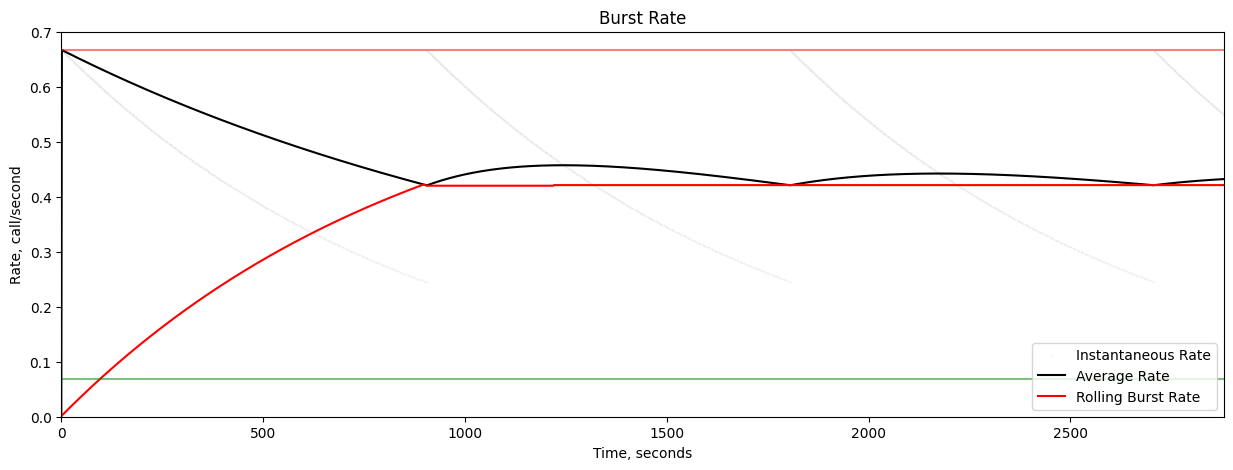

In [183]:
def show_burst_rate(results, burst, sustained):
    plt.figure(figsize=(15, 5))
    plt.title('Burst Rate')

    plt.scatter(results.time, results.rate, marker='.', s=1, alpha=0.05, color='k', label='Instantaneous Rate')
    plt.plot(results.time, results.avg_rate, color='k', label='Average Rate')
    plt.plot(results.time, results.burst_rate, color='red', label='Rolling Burst Rate')

    plt.axhline(burst.rate, color='red', alpha=0.5)
    plt.axhline(sustained.rate, color='green', alpha=0.5)

    plt.legend()
    plt.xlim(0, 3.2*burst.period)
    plt.ylim(0, None)
    plt.xlabel("Time, seconds")
    plt.ylabel("Rate, call/second")
    plt.show()

show_burst_rate(results, burst, sustained)

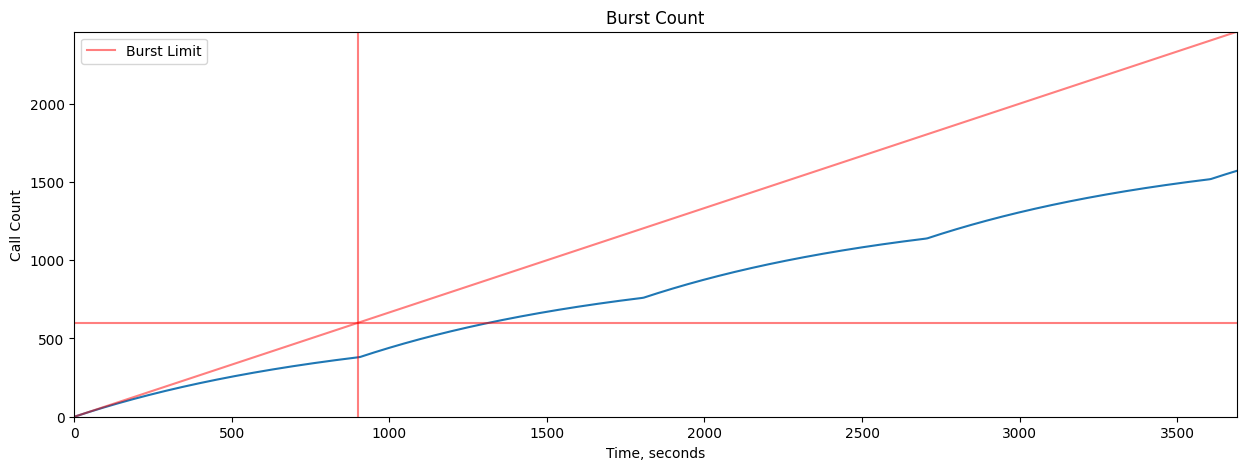

In [85]:
def show_burst_count(results, burst, sustained):
    plt.figure(figsize=(15, 5))
    plt.title('Burst Count')

    plt.plot(results.time, results.count)
    plt.plot(results.time, burst.rate * results.time, color='red', alpha=0.5)
    plt.axhline(burst.count, color='red', alpha=0.5, label='Burst Limit')
    plt.axvline(burst.period, color='red', alpha=0.5)

    plt.legend()
    plt.xlim(0, 4.1*burst.period)
    plt.ylim(0, 4.1*burst.count)
    plt.xlabel("Time, seconds")
    plt.ylabel("Call Count")
    plt.show()

show_burst_count(results, burst, sustained)

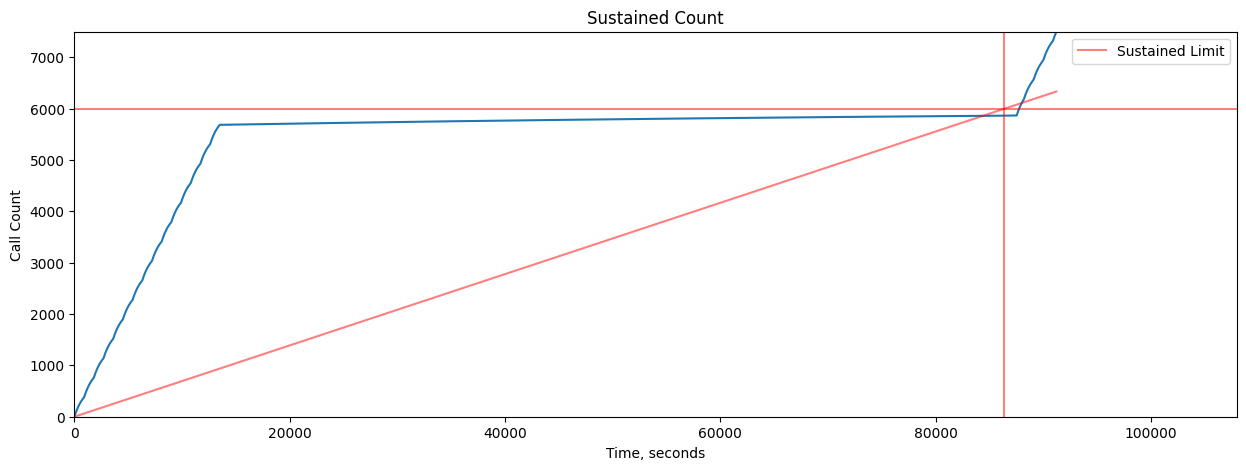

In [86]:
def show_sustained_count(results, burst, sustained):
    plt.figure(figsize=(15, 5))
    plt.title('Sustained Count')

    plt.plot(results.time, results.count)
    plt.plot(results.time, sustained.rate * results.time, color='red', alpha=0.5)
    plt.axhline(sustained.count, color='red', alpha=0.5, label='Sustained Limit')
    plt.axvline(sustained.period, color='red', alpha=0.5)

    plt.legend()
    plt.xlim(0, 1.25*sustained.period)
    plt.ylim(0, 1.25*sustained.count)
    plt.xlabel("Time, seconds")
    plt.ylabel("Call Count")
    plt.show()

show_sustained_count(results, burst, sustained)

In [184]:
throttle_io = ThrottleStateInterface([
    throttle_state_row(id=0, level=0, tat=0, allocation=1),
])

time = TimeWarp()

gcra = GCRA(rate_io, throttle_io, time=time)

# Set up the mock api endpoint
endpoint = MockEndpoint(time, rate_limits, fixed_period=True)

# setup our mock usage of the endpoint
@gcra.throttle()
def api_request(*args, **kwargs):
    return endpoint.make_request(*args, **kwargs)

# Bombard the endpoint with requests
for _ in range(int(1.25*sustained.count)):
    api_request()
    time.sleep(np.random.normal(0, 3)**2)
    if time.time() > 1.25*sustained.period:
        break

simulated = Results(endpoint.log, burst, sustained)
burst.usage = 0
sustained.usage = 0

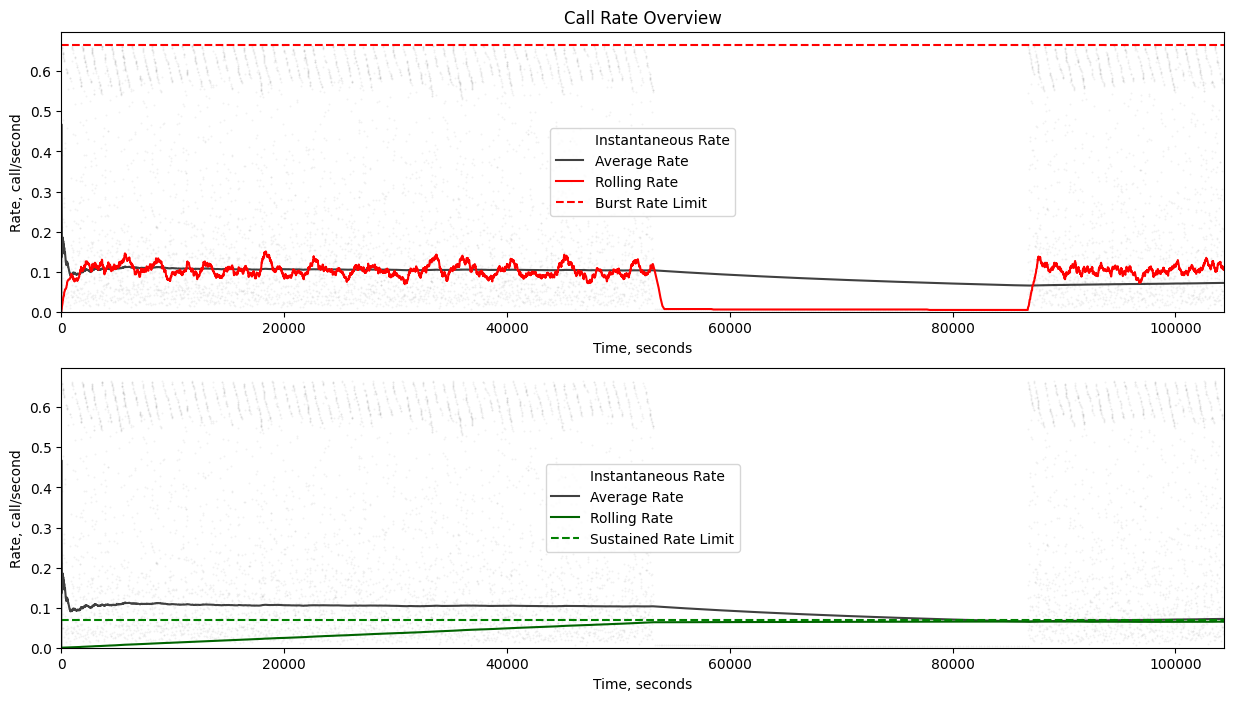

In [185]:
show_overview(simulated, burst, sustained)

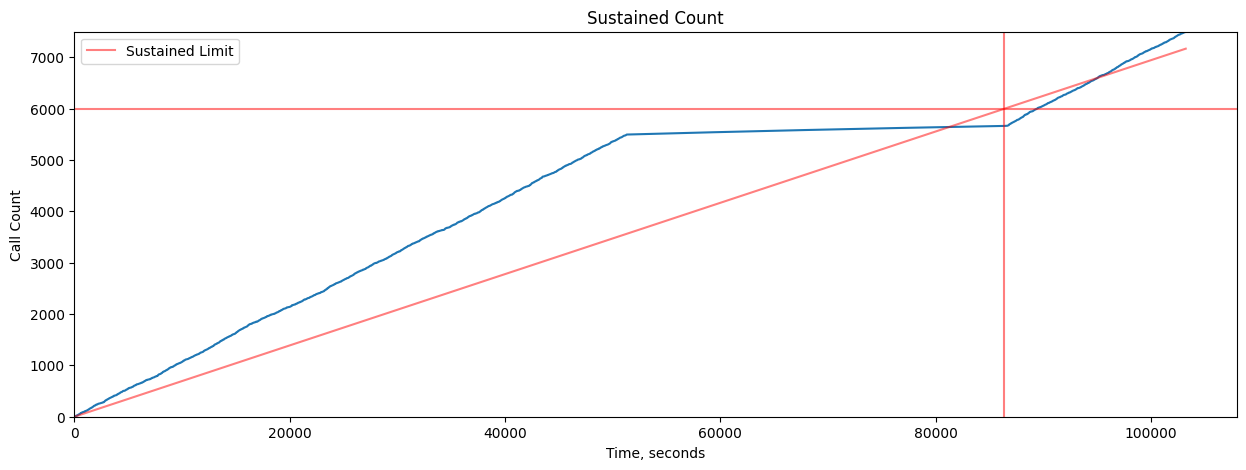

In [109]:
show_sustained_count(simulated, burst, sustained)